<center>
    <h1>Identifying the Human Values behind Arguments</h1>
    <h1>04 - Main Model</h1>
    <h2>Natural Language Processing</h2>
    <h3>Antonio Politano, Enrico Pittini, Riccardo Spolaor and Samuele Bortolato</h3>
    <h4>antonio.politano2@studio.unibo.it, enrico.pittini@studio.unibo.it, riccardo.spolaor@studio.unibo.it, samuele.bortolato@studio.unibo.it</h4>
</center>

---

In this notebook a *Main Model* is proposed for the *Identifying the Human Values behind Arguments* task and evaluated on the provided dataset.

For more detailed informations about the used functions, look into the corresponding docstrings inside the python files, inside the `src` folder.

In [1]:
# EXPERIMENT PARAMETERS

TEST_NAME = 'base'
STANCE = False
AUGMENTATION = False
BALANCING = False
GAMMA = 0
THRESHOLD = False
MODEL_NAME = 'distilroberta-base' 
#'bert-base-uncased', 'lstm', 'prajjwal1/bert-tiny', 'roberta-base', 'distilroberta-base'

from torch import cuda
DEVICE = 'cuda' if cuda.is_available() else 'cpu'

# Set the number of epochs.
EPOCHS = 2
# Set the learning rates for the Bert model and the Classification head.
LEARNING_RATE = 2e-05
LEARNING_RATE_CLASSIFIER = 1e-03
# Set how many training steps to use for validation.
valididations_per_epoch = 2

c:\Users\Sam\miniconda3\envs\torch\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Settings for autoreloading.

%load_ext autoreload
%autoreload 2

In [3]:
# Settings for reproducibility.

from src.utils.seeder import set_random_seed

SEED = 42
set_random_seed(SEED)

## Download of the Dataset

The dataset is given as already split into train and test. In particular, these two datasets are divided into:
* The `arguments` set, which contains instances expressing a position on a specific argument. They are represented as follows:
    * An argument *premise*.
    * The *stance* regarding the argument (either *in favor* or *against*).
    * The *conclusion* on the topic.
* The respective `labels` set, which is comprised of a *multi-label* vector specifying which *Human Values* are related to the correspomnding argument. Hence an argument can refer to more than one *Human Value*. The total number of considered *Human Value* labels is $20$.

In [4]:
from src.datasets.dataset_builder import get_dataframes

arguments_train_df, labels_train_df = get_dataframes('data', 'training')
arguments_test_df, labels_test_df = get_dataframes('data', 'validation')

In [5]:
TARGETS = labels_train_df.columns.to_list()

The validation dataset is obtained by taking a randomly selected $20 \%$ portion of the training dataset. The *seed* provides reproducible results. Furthermore, the `train_test_split` *scikit-learn* function in used to guarantee the split maintains label balance.

In [6]:
import os
from src.datasets.dataset_builder import split_dataframes

(arguments_train_df, labels_train_df), (arguments_val_df, labels_val_df) = \
                split_dataframes(   arguments_train_df, 
                                    labels_train_df, 
                                    seed=SEED,
                                    augmented_premises_file = os.path.join('data', 'augmented-premises.txt') if AUGMENTATION else None)

# Model and Tokenizer Definition

The selected model for the task is the *bert-base-uncased pre-trained language model* and the respective *tokenizer*. 

The special tokens `[AGN]`, `[FAV]` are added to the tokenizer to encode the stance of each input instance.

The model and tokenizer have been instantiated to handle the *multi-label classification* problem type.

In [7]:
if MODEL_NAME=='lstm':

    from src.embeddings.embedding_matrix import load_embedding_model

    # Set the dimension of the embeddings to load.
    EMBEDDING_DIMENSION = 100

    # Get the GLOVE embeddings.
    GLOVE_embeddings = load_embedding_model(folder_path='./data',
                                            embedding_dim=EMBEDDING_DIMENSION)
    
    from src.embeddings.vocabulary import get_texts_from_arguments_dataframes

    # Build a dictionary to encde the stance.
    stance_encoder = { 'in favor of': '[FAV]', 'against': '[AGN]' }

    # Get a list of all the sentences in the datasets in the form
    # '<premise> [FAV]/[AGN] <conclusion>'
    texts = get_texts_from_arguments_dataframes(
        stance_encoder, arguments_train_df, arguments_val_df, arguments_test_df)

    from src.embeddings.vocabulary import get_vocabulary

    # Get the vocabulary and the tokenizer.
    vocabulary, tokenizer = get_vocabulary(texts)

    from src.embeddings.embedding_matrix import build_embedding_matrix

    # Get the embedding matrix from GLOVE and the given vocabulary.
    embedding_matrix = build_embedding_matrix(
        vocabulary=vocabulary, GLOVE_embeddings=GLOVE_embeddings,
        embedding_dimension=EMBEDDING_DIMENSION)

    from src.models.lstm_model import LSTM

    model = LSTM(DEVICE, embedding_matrix, len(TARGETS))

else:
    
    from transformers import AutoTokenizer, logging
    
    # Set verbosity at "error" level
    logging.set_verbosity_error()

    tokenizer = AutoTokenizer.from_pretrained(
        MODEL_NAME, problem_type='multi_label_classification')

    # Add the tokens encoding the stance to the tokenizer.
    tokenizer.add_tokens(['[FAV]', '[AGN]'], special_tokens=True)

    # Build a dictionary to encde the stance.
    stance_encoder = {'in favor of': '[FAV]', 'against': '[AGN]'}

    from src.models.transformer_model  import get_transformer_model

    model = get_transformer_model(MODEL_NAME, num_labels=len(TARGETS),
                              tokenizer=tokenizer, device=DEVICE)


print('Model structure:')
print(model)

Model structure:
RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50267, 768)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0): RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (Laye

## Training

### Create Dataloaders

The train, validation and test dataloaders are created. The *batch size* for the train dataloader is set at $8$, while the one for the validation and test dataloader is set at $16$.

Data Augmentation is applied only for the train dataloader. In particular, one of the following inputs of each argument instance is randomly selected when the batch is loaded.
* The premise.
* The conclusion.
* The premise followed by the stance and the conclusion.

Shuffling is applied just on the train dataloader.

In [8]:
from src.datasets.dataloader_builder import get_dataloader

BATCH_SIZE_TRAIN = 8
BATCH_SIZE_EVAL = 16

if MODEL_NAME == 'lstm':
    train_loader = get_dataloader(arguments_train_df, labels_train_df, tokenizer,
                                stance_encoder, is_transformer=False, 
                                batch_size=BATCH_SIZE_TRAIN, shuffle=True,
                                use_all_instance=STANCE)
    val_loader = get_dataloader(arguments_val_df, labels_val_df, tokenizer,
                                stance_encoder, is_transformer=False,
                                batch_size=BATCH_SIZE_EVAL, shuffle=False,
                                use_all_instance=STANCE)
    test_loader = get_dataloader(arguments_test_df, labels_test_df, tokenizer,
                                stance_encoder, is_transformer=False,
                                batch_size=BATCH_SIZE_EVAL, shuffle=False,
                                use_all_instance=STANCE)
else:
    train_loader = get_dataloader(arguments_train_df, labels_train_df, tokenizer,
                                stance_encoder, is_transformer=True, 
                                batch_size=BATCH_SIZE_TRAIN, shuffle=True,
                                use_all_instance=STANCE)
    val_loader = get_dataloader(arguments_val_df, labels_val_df, tokenizer,
                                stance_encoder, is_transformer=True,
                                batch_size=BATCH_SIZE_EVAL, shuffle=False,
                                use_all_instance=STANCE)
    test_loader = get_dataloader(arguments_test_df, labels_test_df, tokenizer,
                                stance_encoder, is_transformer=True,
                                batch_size=BATCH_SIZE_EVAL, shuffle=False,
                                use_all_instance=STANCE)

### Training parameters

The following training parameters have been selected:
* The number of *epochs* is set at $15$.
* *Adam* is used as an optimizer.
    * The *learning rate* of the *bert language model* part of the model is set at $2e-05$, to apply a less severe tuning of the language model.
    * The *learning rate* of the *classification head* of the model is increased at $1e-03$ to tune the model more specifically in its classification task.
* The number of *validation steps* is set at $200$. They indicate after how many batch steps the evaluation of the model on the validation set occurs.
* The chosen loss function is the *Focal Loss*. It downweights easy examples to classify and upweights hard examples by weighting to the classical *binary cross-entropy* to focus the training on the hard samples to classify. The loss function is weighted to handle also the class unbalance which is estimated on the label frequencies of the train set.
* A checkpoint monitor is introduced to save the best model weights according to the validation set best evaluation scores.
* An early stopping monitor is introduced to stop the training if the evaluation score does not improve after a certain number of steps.

In [9]:
import os
from torch.optim import Adam
from src.training.training_utils import Checkpoint, EarlyStopping, FocalLoss


STEPS_VALIDATE = len(train_loader)//valididations_per_epoch + 1

# Set the loss function.
train_labels_frequencies = (labels_train_df.sum() / len(labels_train_df)).to_numpy()
loss_function = FocalLoss(alpha=train_labels_frequencies if BALANCING else 0.5, gamma=GAMMA)

if (MODEL_NAME == 'bert-base-uncased') or (MODEL_NAME == 'prajjwal1/bert-tiny'):
    # Set the optimizer.
    optimizer = Adam(params=[
        { 'params': model.bert.parameters(), 'lr': LEARNING_RATE },
        { 'params': model.dropout.parameters(), 'lr': LEARNING_RATE_CLASSIFIER },
        { 'params': model.classifier.parameters(), 'lr': LEARNING_RATE_CLASSIFIER }
        ])
elif (MODEL_NAME == 'roberta-base') or (MODEL_NAME == 'distilroberta-base'):
    # Set the optimizer.
    optimizer = Adam(params=[
        { 'params': model.roberta.parameters(), 'lr': LEARNING_RATE },
        { 'params': model.classifier.parameters(), 'lr': LEARNING_RATE_CLASSIFIER }
        ])
elif (MODEL_NAME == 'lstm'):
    # Set the optimizer.
    optimizer = Adam(model.parameters(), lr=LEARNING_RATE)
else:
    raise Exception("Unsupported model")

# Set the checkpoints and the early stopping monitor.
checkpoint = Checkpoint(model, path=os.path.join('models', f"{MODEL_NAME}_seed{SEED}.pth"))
early_stopping = EarlyStopping()

### Training

In [10]:
from src.training.training import train
# Train the model

if MODEL_NAME=='lstm':
    train_loss_history, val_loss_history, val_f1_macro_history = train(
        train_loader, val_loader, model, optimizer, loss_function, DEVICE,
        epochs=EPOCHS, steps_validate=STEPS_VALIDATE, checkpoint=checkpoint,
        early_stopping=early_stopping, reload_best_weights=True,
        use_threshold_selection=True)
else:
    train_loss_history, val_loss_history, val_f1_macro_history = train(
        train_loader, val_loader, model, optimizer, loss_function, DEVICE,
        epochs=EPOCHS, steps_validate=STEPS_VALIDATE, checkpoint=checkpoint,
        early_stopping=early_stopping, reload_best_weights=True,
        use_threshold_selection=False)

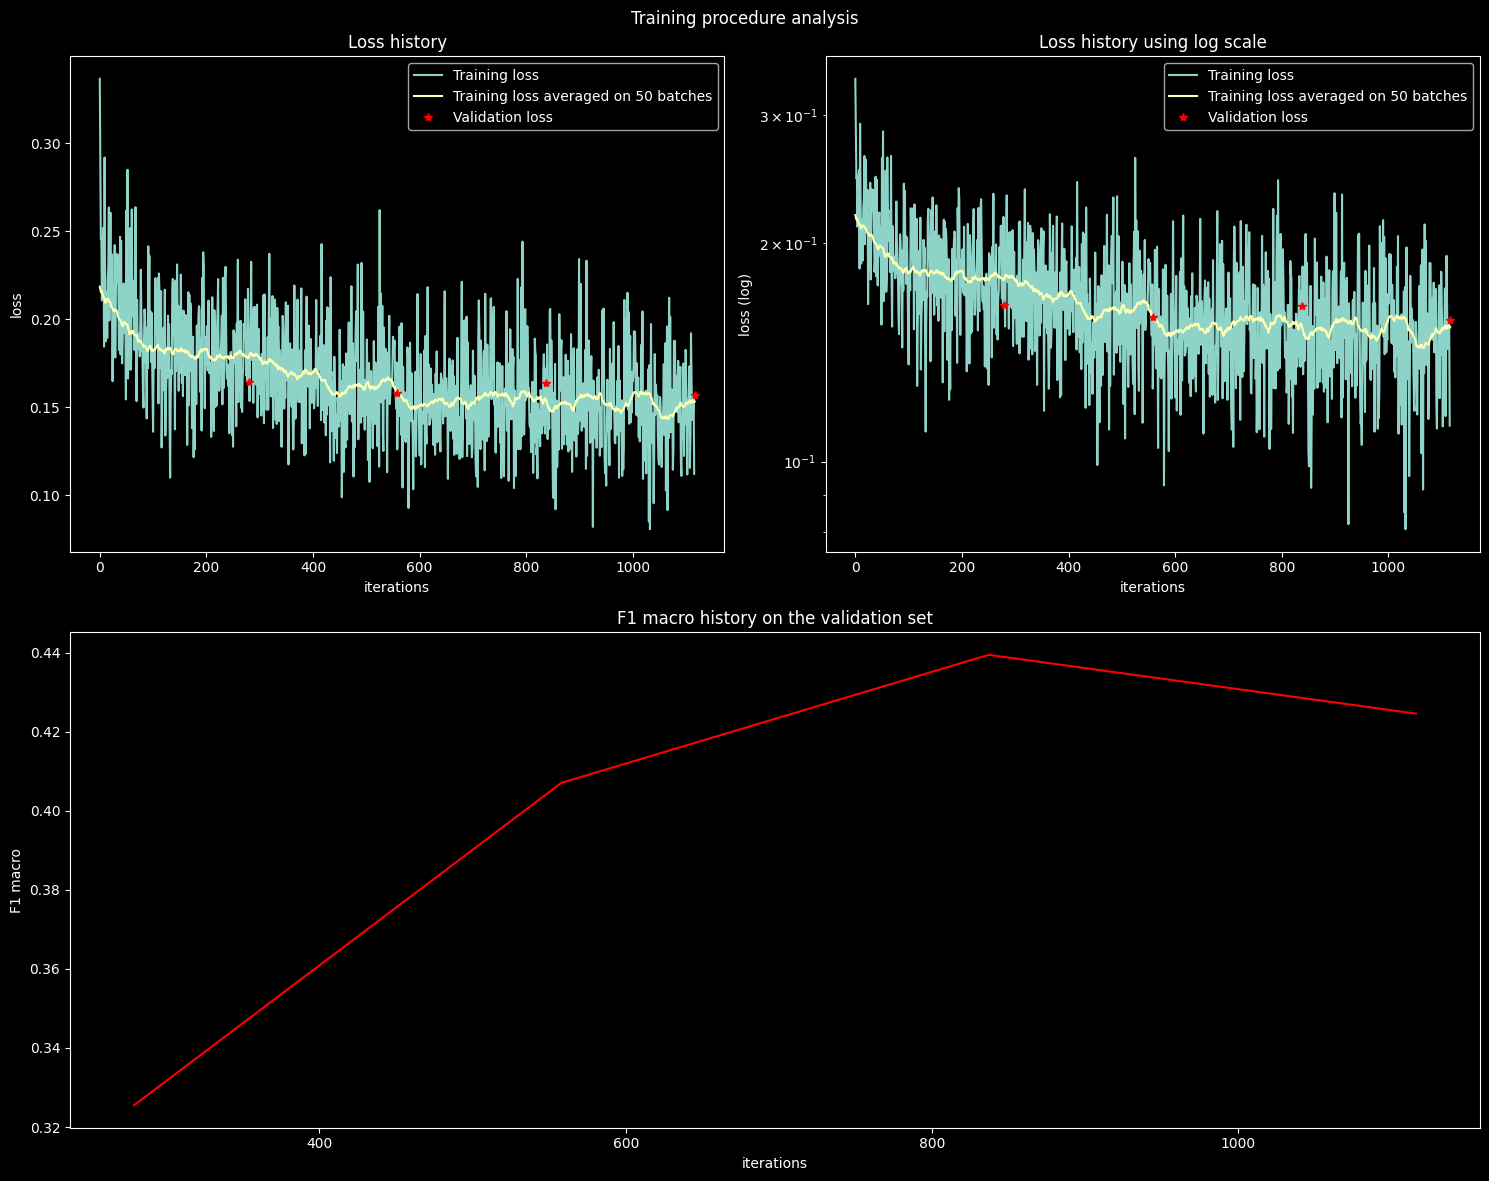

In [ ]:
from src.training.training_analysis import plot_training_history

plot_training_history(train_loss_history, val_loss_history,
                      val_f1_macro_history)

# Model Evaluation

## Threshold selection
In this section, the threshold selection procedure is illuatrated

The *Receiver Operating Characteristic Curves* illustrate the true and false positive rate relation when the threshold varies on each label. A threshold selection operation is necessary to obtain better results.

Macro-averaged One-vs-Rest ROC AUC score:
0.82


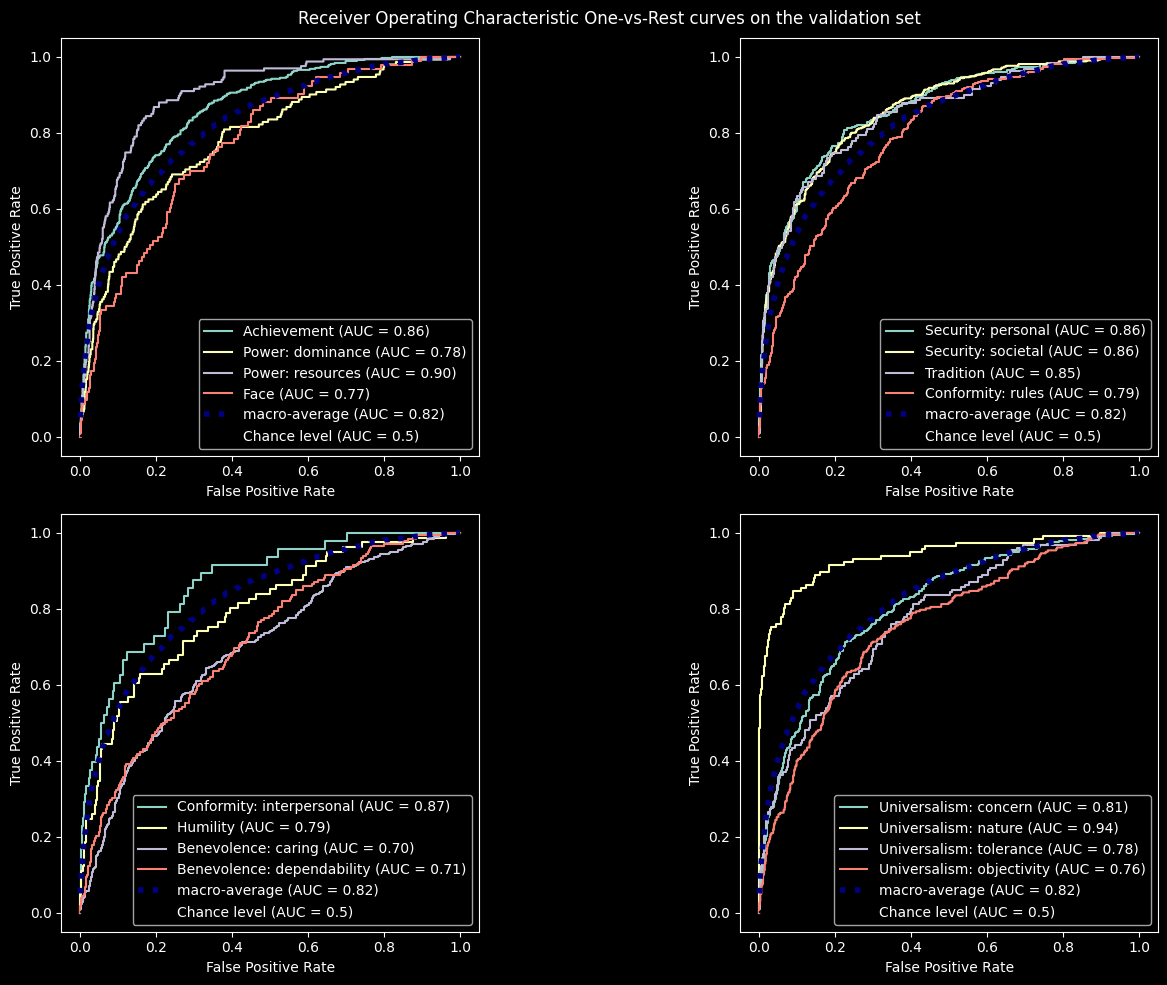

In [ ]:
from src.evaluation.evaluation import get_dataset_prediction_scores
from src.evaluation.evaluation_analysis import plot_roc_curves

y_scores, y_true = get_dataset_prediction_scores(model, val_loader, DEVICE)
plot_roc_curves(y_true, y_scores, TARGETS, 'validation')

To select the best thresholds, the *precision*, *recall* and *F1-score* have been computed on all possible thresholds on the validation dataset for all possible labels.

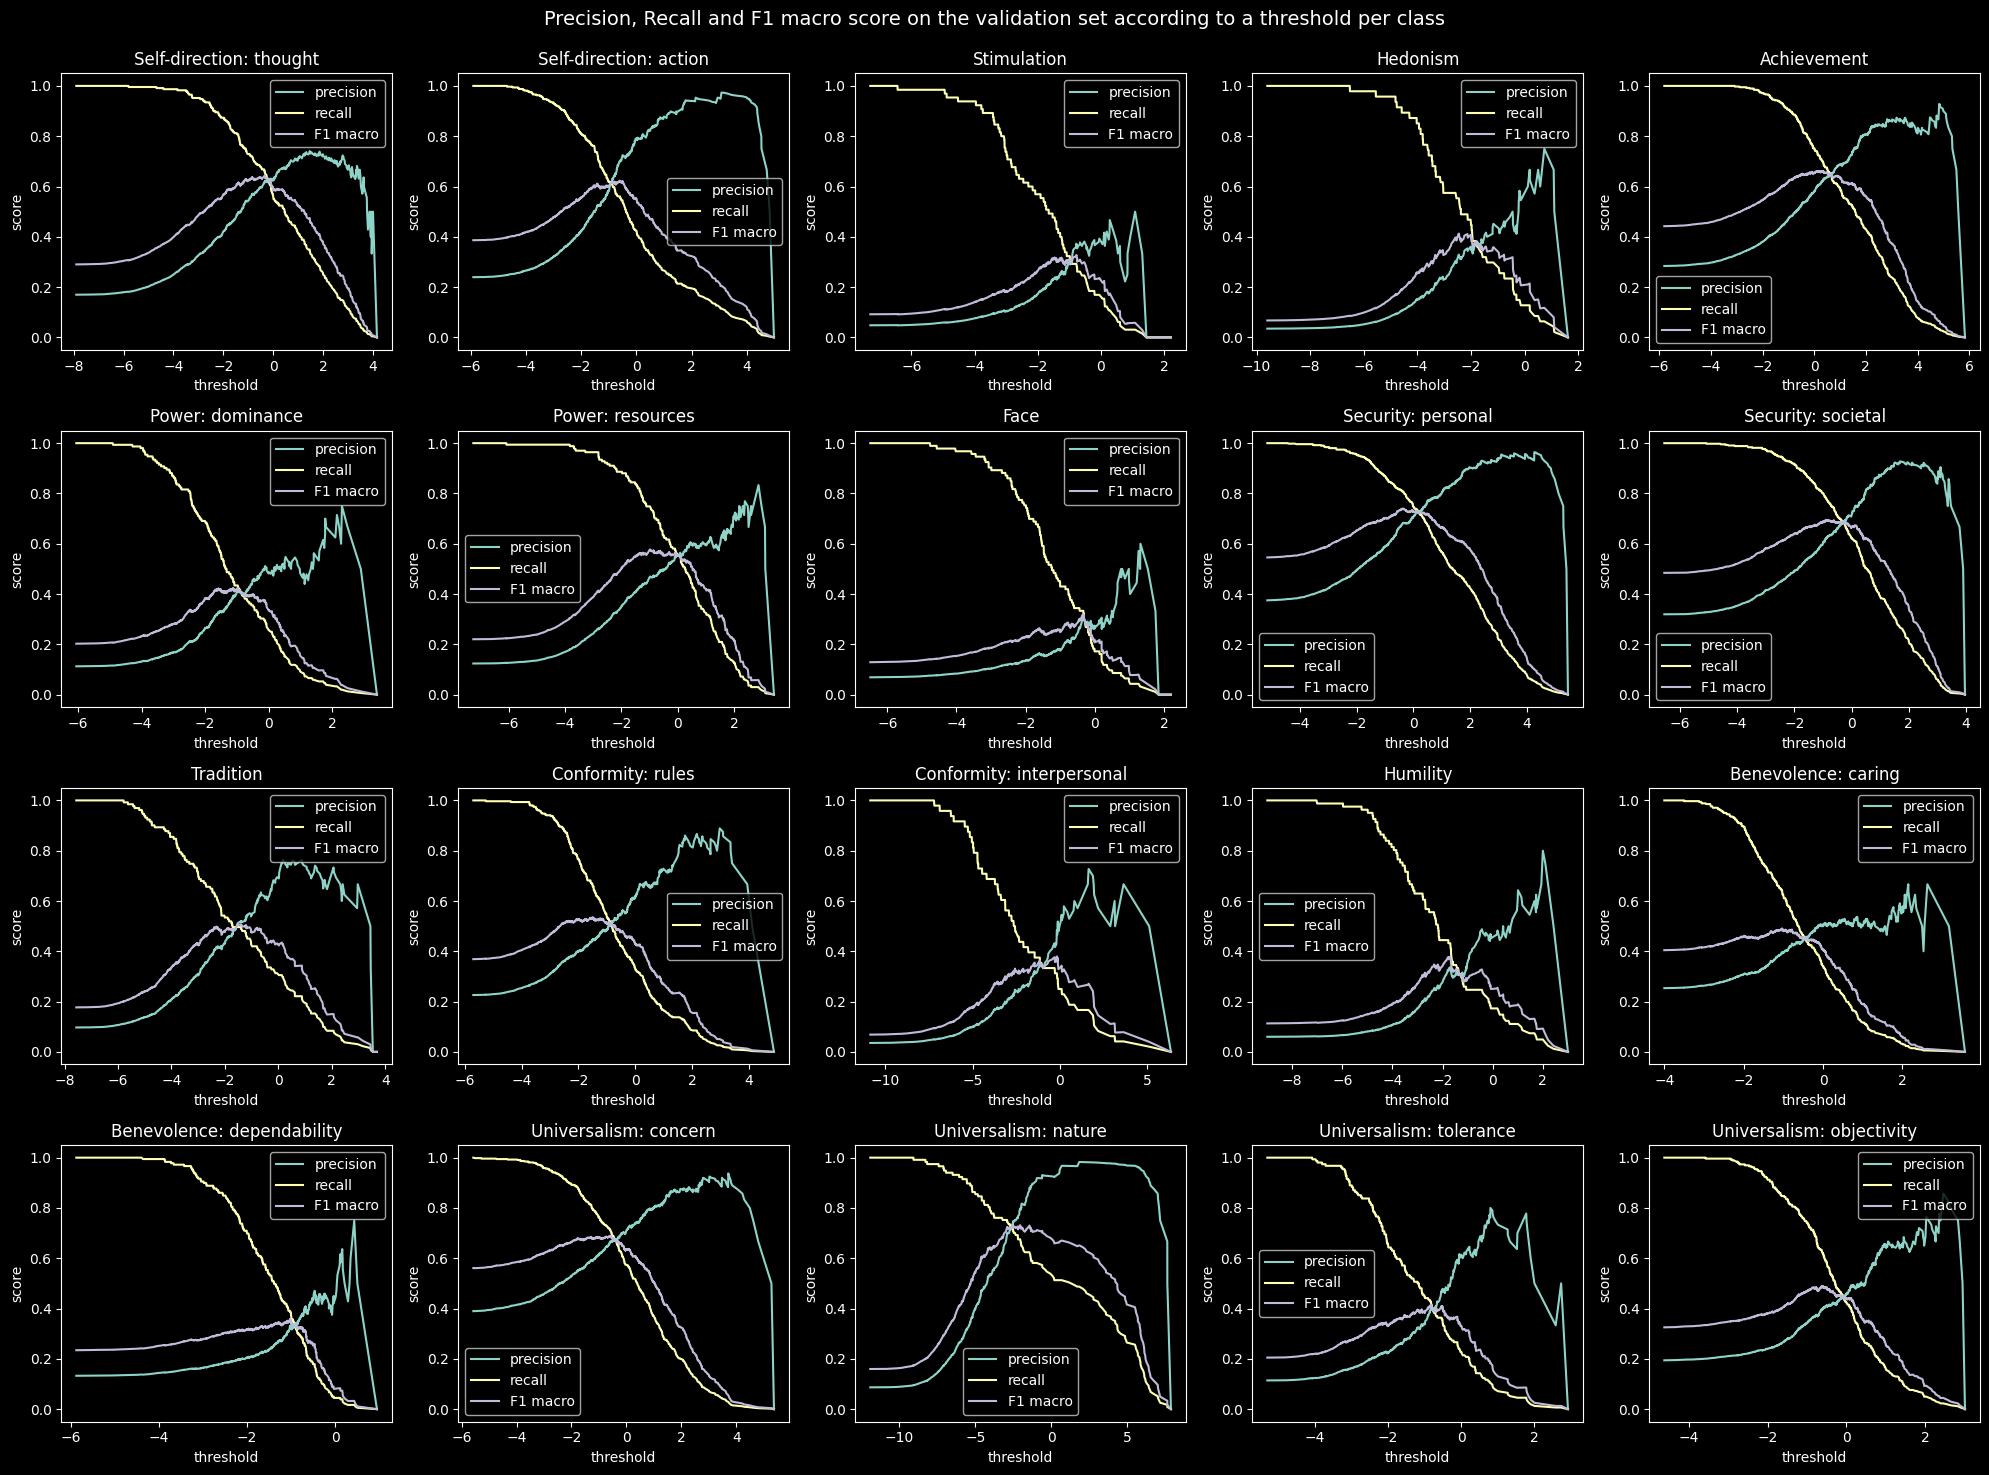

In [ ]:
from src.evaluation.evaluation_analysis import (
    plot_precision_recall_f1_macro_curves)

plot_precision_recall_f1_macro_curves(y_true, y_scores, TARGETS, 'validation')

The thresholds that for each label maximize the *F1 score* on the validation set have been selected.

In [ ]:
from src.evaluation.evaluation import get_best_thresholds
import numpy as np

# Get the best thresholds.
thresholds_per_target = get_best_thresholds(y_true, y_scores)

# Save the best thresholds.
np.save(os.path.join('models', 'main_model_thresholds.npy'),
        thresholds_per_target)

for target, thresh in zip(TARGETS, thresholds_per_target):
    print(f'"{target}" best threshold: {thresh:.4f}')

"Self-direction: thought" best threshold: -0.3489
"Self-direction: action" best threshold: -0.5975
"Stimulation" best threshold: -0.7739
"Hedonism" best threshold: -2.4493
"Achievement" best threshold: 0.1263
"Power: dominance" best threshold: -0.9715
"Power: resources" best threshold: -0.9872
"Face" best threshold: -0.3325
"Security: personal" best threshold: -0.3563
"Security: societal" best threshold: -0.8742
"Tradition" best threshold: -1.3971
"Conformity: rules" best threshold: -1.5058
"Conformity: interpersonal" best threshold: -0.1752
"Humility" best threshold: -1.6895
"Benevolence: caring" best threshold: -1.0324
"Benevolence: dependability" best threshold: -1.0282
"Universalism: concern" best threshold: -0.5836
"Universalism: nature" best threshold: -2.0387
"Universalism: tolerance" best threshold: -0.8287
"Universalism: objectivity" best threshold: -0.5872


## Evaluation on the Validation set

In this section the model performances are evaluated on the validation set.

In [ ]:
from sklearn.metrics import f1_score
from src.evaluation.evaluation import get_dataset_predictions

y_pred, y_true = get_dataset_predictions(model, val_loader, DEVICE)

# Compute Validation F1 macro score.
f1_macro = f1_score(y_true=y_true, y_pred=y_pred, average='macro')

print('Validation f1-score macro on the validation set with base threshold 0:', 
      f'{f1_macro:.3f}')

Validation f1-score macro on the validation set with base threshold 0: 0.439


In [ ]:
from src.evaluation.evaluation_analysis import print_classification_report

print_classification_report(y_true, y_pred, TARGETS, 'validation')

Classification report for the validation set:
                            precision    recall  f1-score   support

   Self-direction: thought       0.63      0.56      0.59       229
    Self-direction: action       0.79      0.42      0.55       323
               Stimulation       0.41      0.17      0.24        65
                  Hedonism       0.60      0.13      0.21        47
               Achievement       0.58      0.75      0.66       383
          Power: dominance       0.49      0.26      0.34       152
          Power: resources       0.56      0.56      0.56       167
                      Face       0.27      0.17      0.21        93
        Security: personal       0.71      0.75      0.73       506
        Security: societal       0.71      0.62      0.67       431
                 Tradition       0.71      0.31      0.43       131
         Conformity: rules       0.62      0.33      0.43       305
 Conformity: interpersonal       0.52      0.25      0.34        48
 

In the chart below the support and the computed classification metrics for each label are showed (ordered by increasing *f1-score*).

It can be noticed that the 4 labels with the worst *f1-score* have a quite low supported compared to the others.

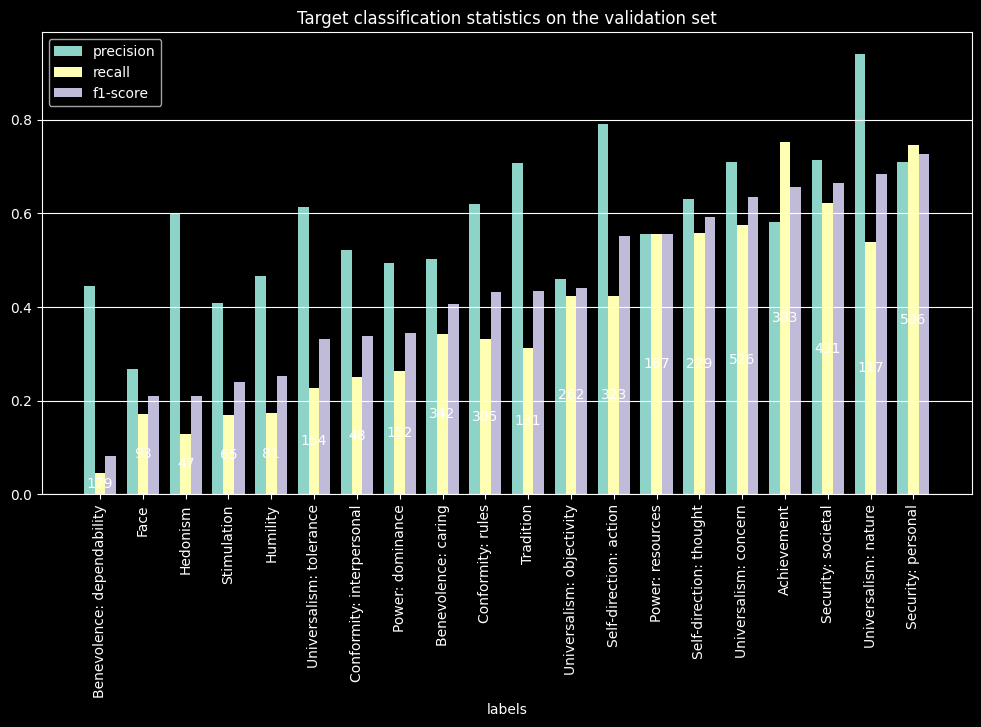

In [ ]:
from src.evaluation.evaluation_analysis import \
    plot_targets_classification_statistics

plot_targets_classification_statistics(y_true, y_pred, TARGETS, 'validation')

Since a multi-label classification task is addressed, a confusion matrix for each label is presented in order to capture the model's performances.

As the matrices show the model predicts few false negatives, although for some labels (such as *Humilty* and *radition*) the false positives are way higher.

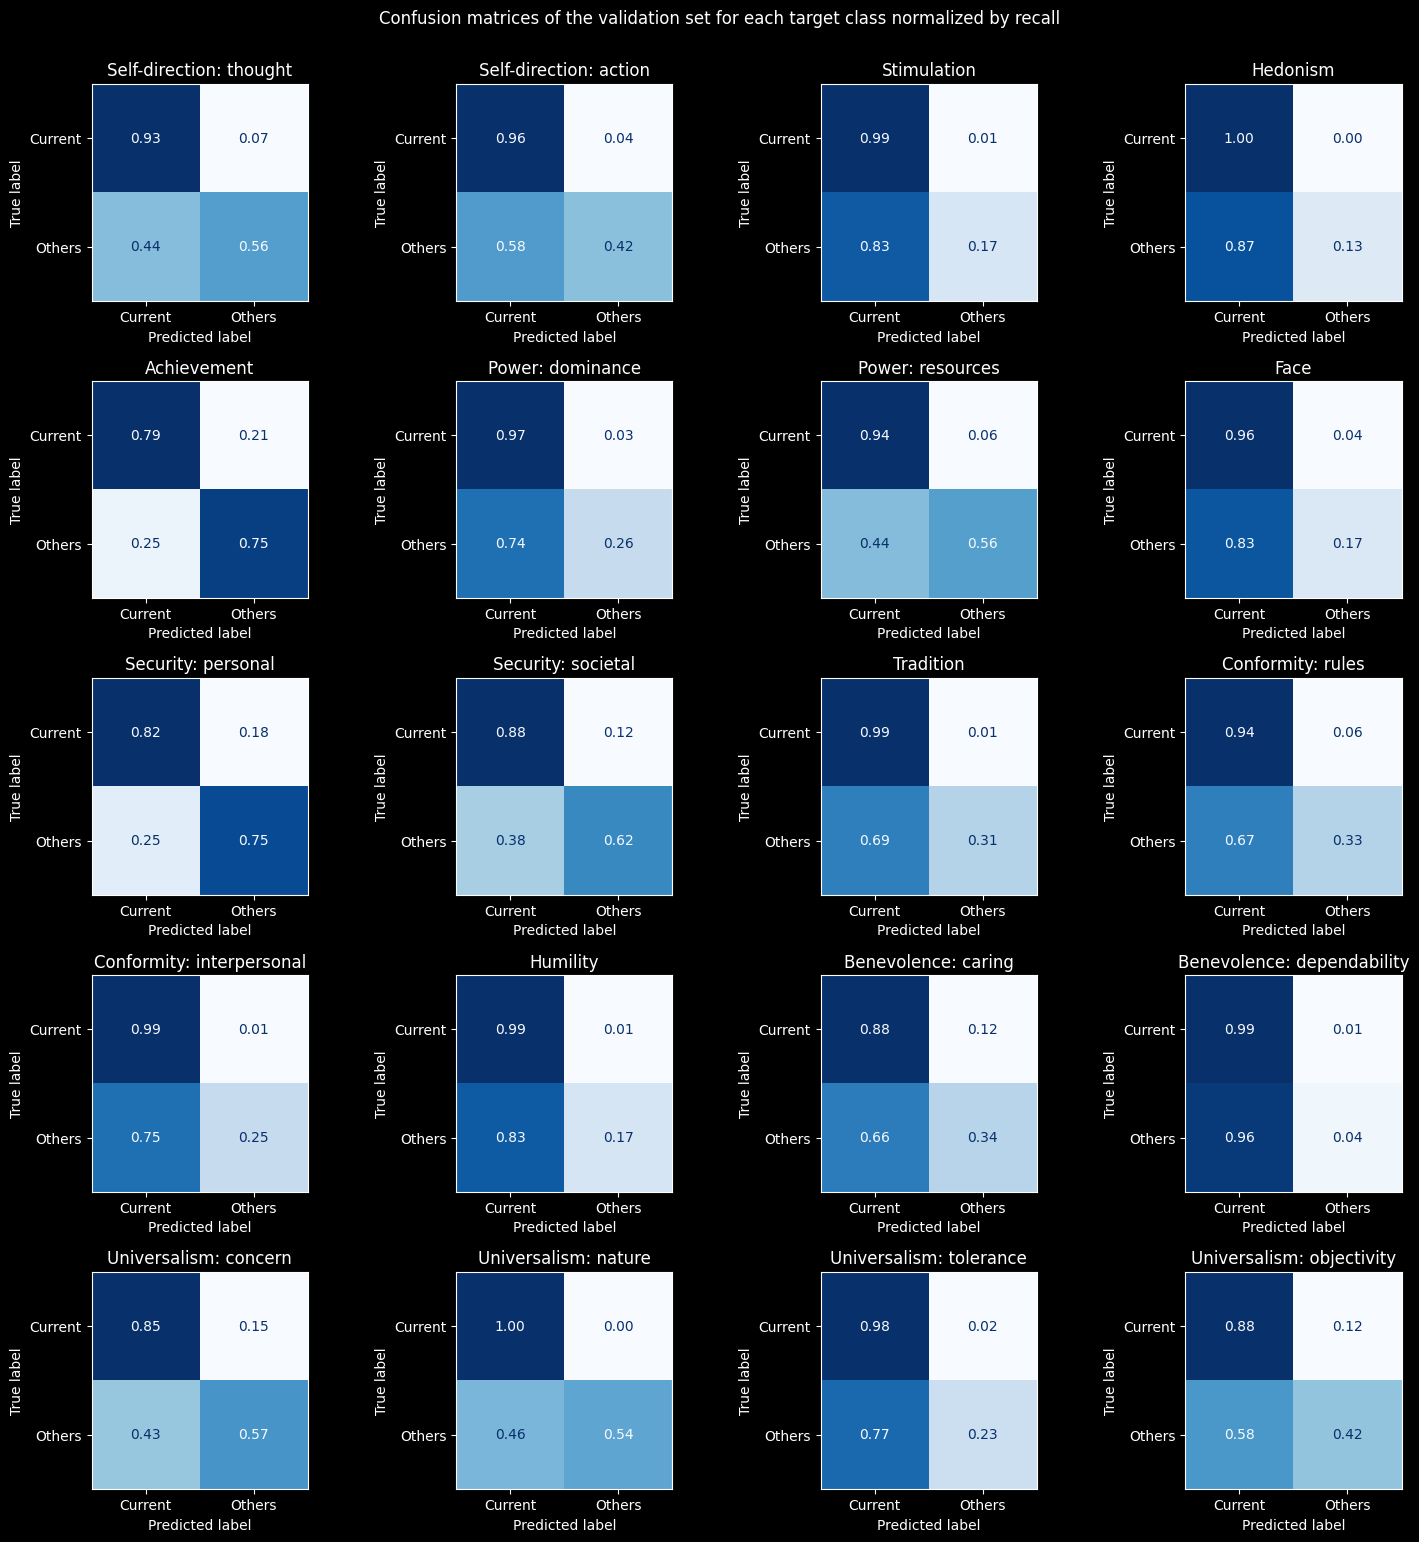

In [ ]:
from src.evaluation.evaluation_analysis import plot_confusion_matrices

plot_confusion_matrices(y_true, y_pred, TARGETS, 'validation',
                        normalize_by='recall')

## Evaluation on the Test set

In this section the model performances are evaluated on the test set.

In [ ]:
from sklearn.metrics import f1_score
from src.evaluation.evaluation import get_dataset_predictions

y_pred, y_true = get_dataset_predictions(model, test_loader, DEVICE)

# Compute Test F1 macro score.
f1_macro = f1_score(y_true=y_true, y_pred=y_pred, average='macro')

print('Validation f1-score macro on the test set with base threshold 0:',
      f'{f1_macro:.3f}')

Validation f1-score macro on the test set with base threshold 0: 0.366


In [ ]:
from sklearn.metrics import f1_score
from src.evaluation.evaluation import get_dataset_predictions

y_pred, y_true = get_dataset_predictions(model, test_loader, DEVICE,
                                         thresholds_per_target)

# Compute Test F1 macro score with threshold selection.
f1_macro = f1_score(y_true=y_true, y_pred=y_pred, average='macro')

print('Validation f1-score macro on the test set with threshold selection:',
      f'{f1_macro:.3f}')

Validation f1-score macro on the test set with threshold selection: 0.443


In [ ]:
from src.evaluation.evaluation_analysis import print_classification_report

print_classification_report(y_true, y_pred, TARGETS, 'test')

Classification report for the test set:
                            precision    recall  f1-score   support

   Self-direction: thought       0.42      0.56      0.48       251
    Self-direction: action       0.67      0.44      0.53       496
               Stimulation       0.36      0.14      0.21       138
                  Hedonism       0.31      0.45      0.37       103
               Achievement       0.61      0.73      0.66       575
          Power: dominance       0.35      0.30      0.32       164
          Power: resources       0.33      0.74      0.46       132
                      Face       0.29      0.19      0.23       130
        Security: personal       0.66      0.82      0.73       759
        Security: societal       0.56      0.73      0.63       488
                 Tradition       0.54      0.38      0.44       172
         Conformity: rules       0.46      0.71      0.56       455
 Conformity: interpersonal       0.37      0.12      0.18        60
       

The support and the computed classification metrics are shown for the test set as well label-wise (in *f1-score* descending order).

As expected the worst ones have lower support and only *Humilty* has less than $0.2$ f1-score.

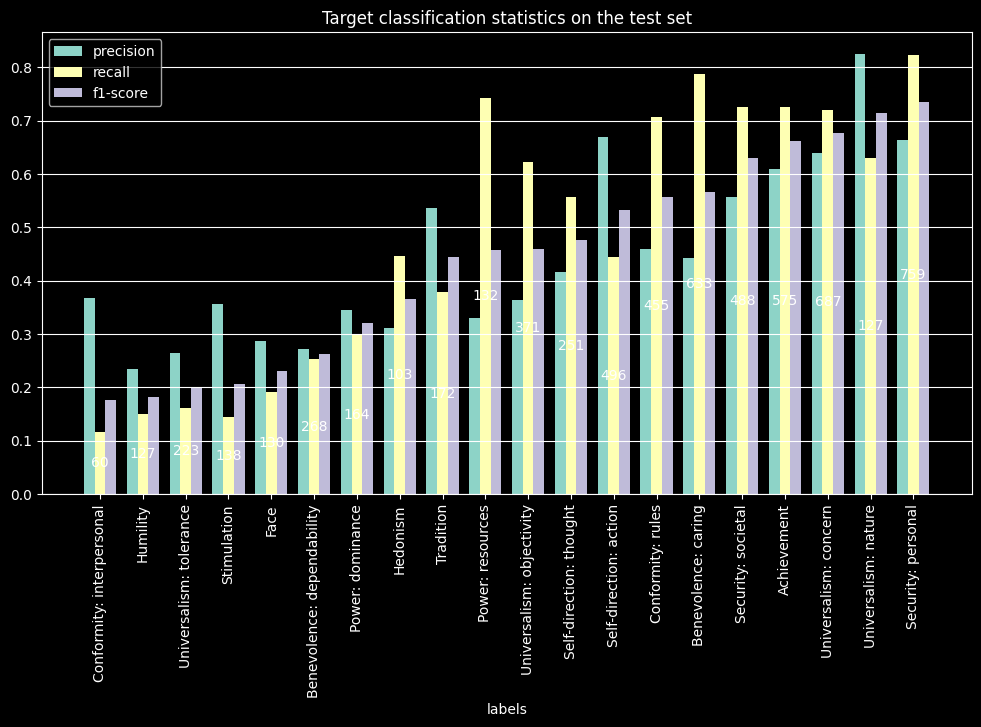

In [ ]:
from src.evaluation.evaluation_analysis import \
    plot_targets_classification_statistics

plot_targets_classification_statistics(y_true, y_pred, TARGETS, 'test')

The confusion matrices for each labels calculated over the test set are shown as well.
Again the false negatives are low for all the labels and just a few present high false positives (*Humilty* and *Power: dominance*)

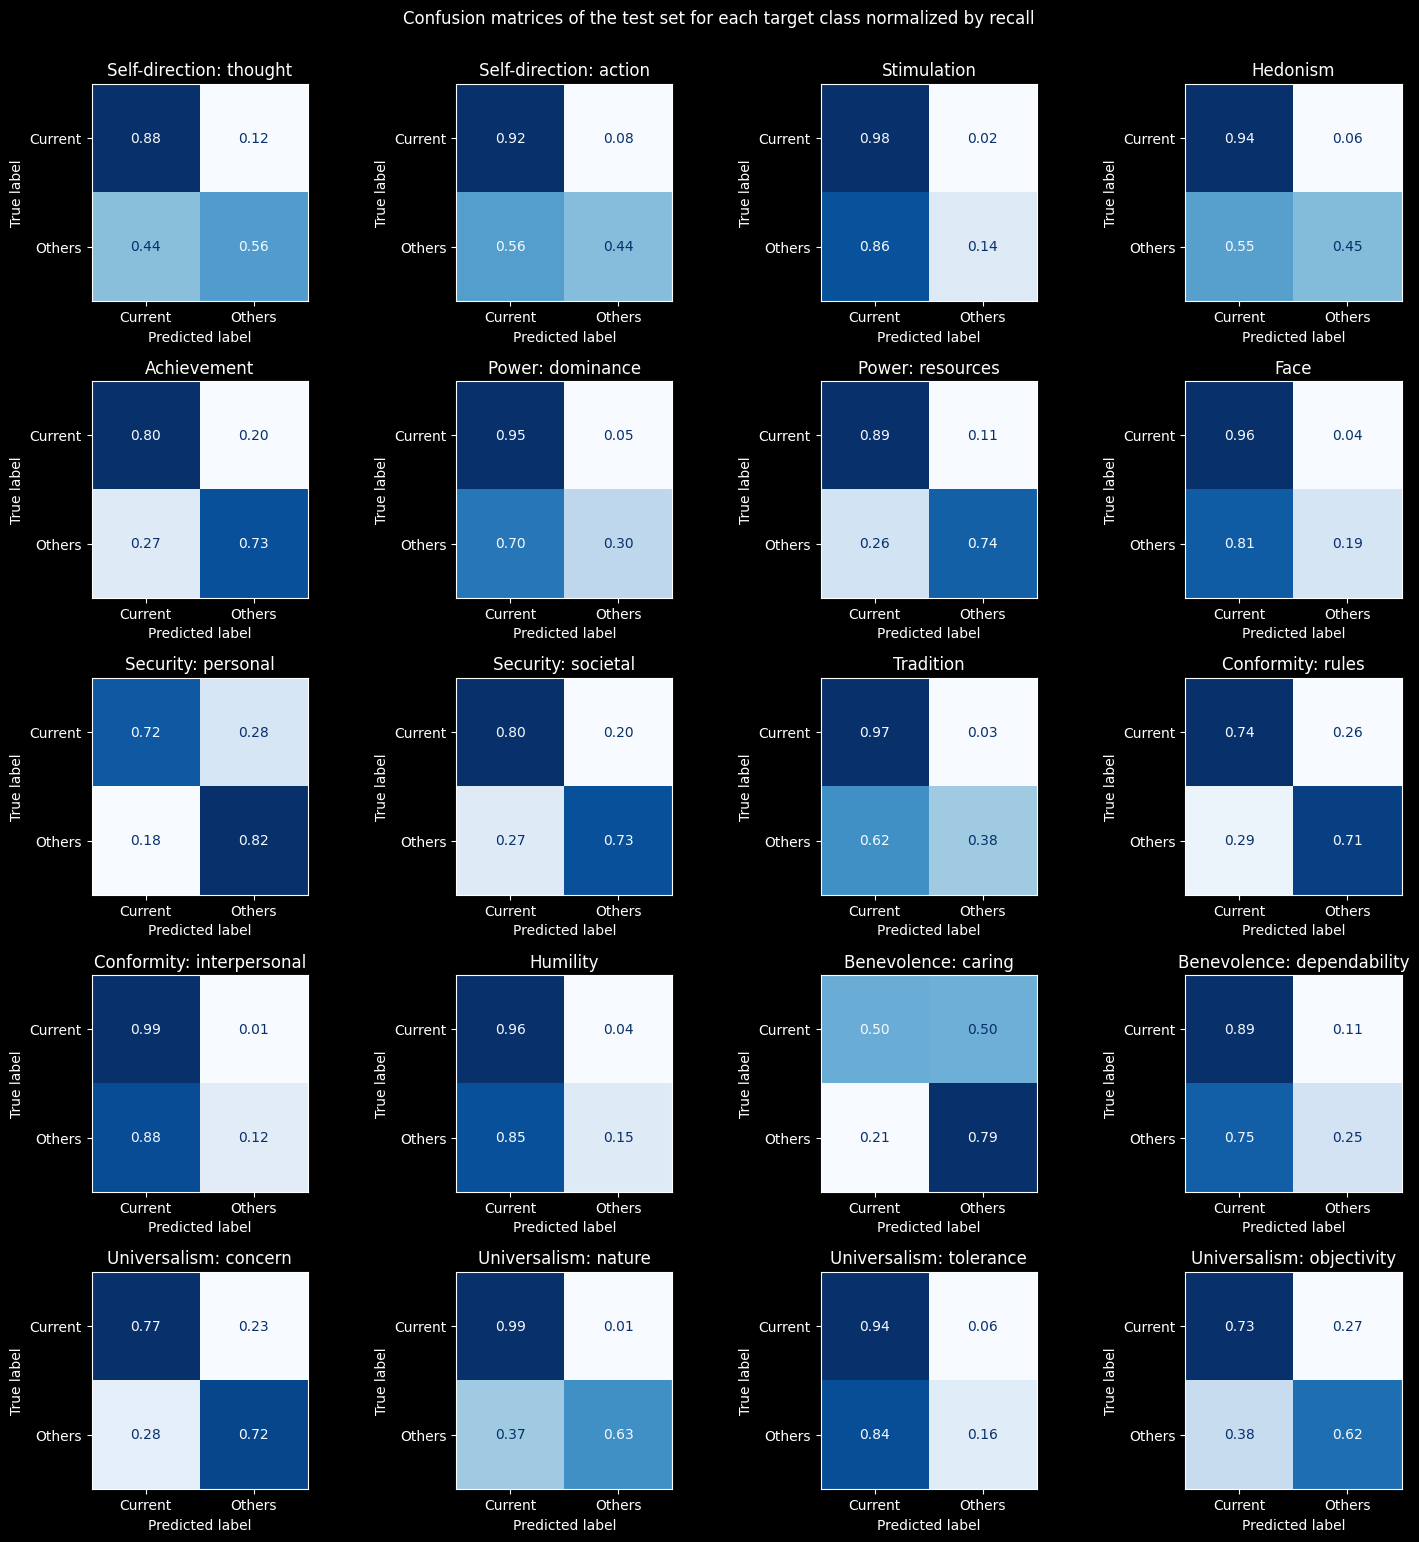

In [ ]:
from src.evaluation.evaluation_analysis import plot_confusion_matrices

plot_confusion_matrices(y_true, y_pred, TARGETS, 'test', normalize_by='recall')

# Error Analysis on the Test Set

In this section the actual error analysis task is performed.

The worst $200$ predicted instances in terms of target label *accuracy* are selected.

In [ ]:
from src.evaluation.error_analysis import get_k_worst_predicted_instances

worst_predicted_instances, worst_predicted_instances_targets = \
    get_k_worst_predicted_instances(arguments_test_df, labels_test_df,
    y_true, y_pred, n_worst_instances=200)

In [ ]:
worst_predicted_instances.head()

,Conclusion,Stance,Premise,Labels
1688,We should limit the use of fireworks,in favor of,Fireworks are an especially selfish source of ...,"[Security: personal, Conformity: rules, Confor..."
626,The vow of celibacy should be abandoned,in favor of,the vow of celibacy should be abandoned becaus...,"[Self-direction: thought, Self-direction: acti..."
1591,Hindi should be the National language of India,against,There are widespread protests against the impo...,"[Security: personal, Humility, Universalism: c..."
366,The vow of celibacy should be abandoned,in favor of,"i consider it a sensitive issue, however, beca...","[Self-direction: action, Stimulation, Hedonism..."
28,Social media brings more harm than good,in favor of,social media brings more harm than good becaus...,"[Self-direction: action, Security: personal, S..."


In [ ]:
worst_predicted_instances_targets.head()

,Self-direction: thought,Self-direction: action,Stimulation,Hedonism,Achievement,Power: dominance,Power: resources,Face,Security: personal,Security: societal,Tradition,Conformity: rules,Conformity: interpersonal,Humility,Benevolence: caring,Benevolence: dependability,Universalism: concern,Universalism: nature,Universalism: tolerance,Universalism: objectivity
1688,0,0,0,0,0,0,0,0,1,0,0,1,1,1,0,1,1,1,0,1
626,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
1591,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0
366,0,1,1,1,0,0,0,0,1,0,0,1,0,0,1,0,0,0,1,0
28,0,1,0,0,0,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0


Among these considered worst predicted instances, the ones having stances *in favor of* the argument are roughly double the number of the ones *against*, suggesting that the model predicts more accurately the arguments with stances *against* them.

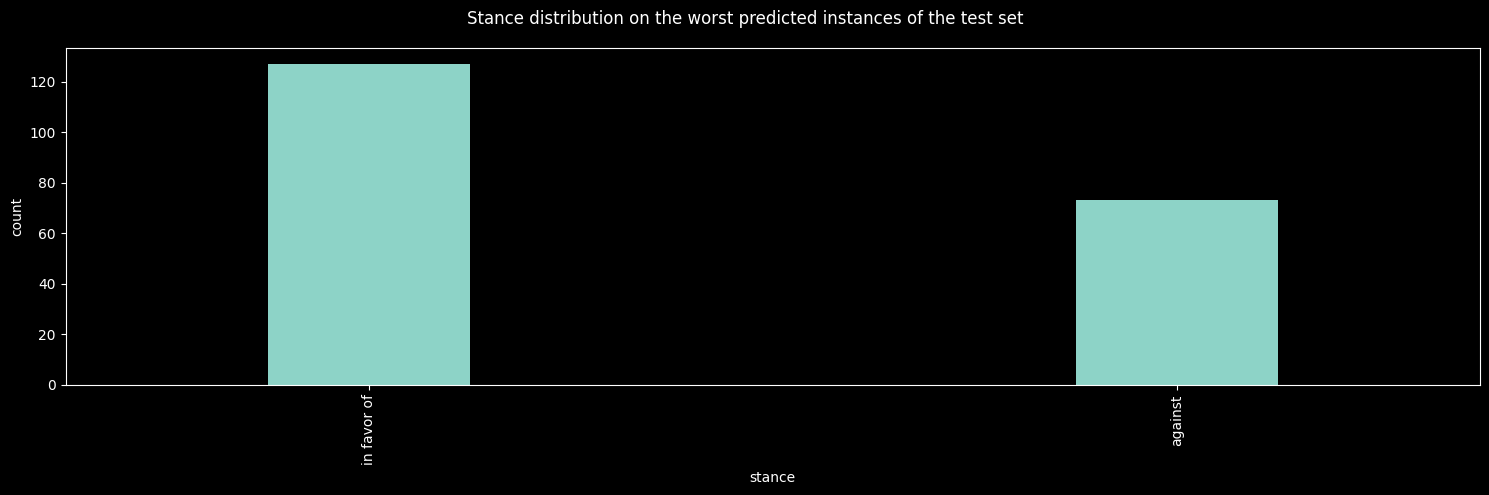

In [ ]:
from src.datasets.dataset_analysis import plot_stance_distribution

plot_stance_distribution(worst_predicted_instances,
                         title='Stance distribution on the worst predicted instances of the test set')

Finally, the worst $5$ instances in terms of accuracy predictions are shown. It is interesting to point out that $3$ of them are about religion, possibly making it a controversial or multi-informative topic.

In [ ]:
from src.evaluation.error_analysis import print_k_worst_predicted_instances

print_k_worst_predicted_instances(worst_predicted_instances, y_true, y_pred,
                                  TARGETS, n_worst_instances=5)

Worst instance 1:
-----------------
Premise: "Fireworks are an especially selfish source of entertainment."
Stance: "in favor of"
Conclusion: "We should limit the use of fireworks"
True targets: "Security: personal; Conformity: rules; Conformity: interpersonal; Humility; Benevolence: dependability; Universalism: concern; Universalism: nature; Universalism: objectivity"
Predicted targets: "Stimulation; Hedonism; Achievement; Benevolence: caring"

Worst instance 2:
-----------------
Premise: "the vow of celibacy should be abandoned because not everyone can hold up to the lifelong commintment"
Stance: "in favor of"
Conclusion: "The vow of celibacy should be abandoned"
True targets: "Self-direction: thought; Self-direction: action; Stimulation; Hedonism; Universalism: tolerance"
Predicted targets: "Security: personal; Tradition; Conformity: rules; Humility; Universalism: concern"

Worst instance 3:
-----------------
Premise: "There are widespread protests against the imposition of Hindi be